# TRANSFORMER ARCHITECTURE FOR INLINED FUNCTION INSTRUCTION IDENTIFICATION

##Step 0: mount Drive and import libraries

In [1]:
from google.colab import drive
import os

#Palmtree imports
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np

#Data preprocessing imports
from pickle import load

#Model training imports
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

#Model testing imports
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

drive.mount('/content/gdrive')

<ipython-input-1-3607b4ce17e8>:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Mounted at /content/gdrive


## Step 1: load Palmtree embedding

Install  bert-pytorch

In [ ]:
!pip install bert-pytorch

Import modules and load [pre-trained PalmTree model](https://github.com/palmtreemodel/PalmTree/tree/master/pre-trained_model)

In [ ]:
os.chdir("/content/gdrive/MyDrive/Tesi/Palmtree")
from config import *
import eval_utils as utils
palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")


Loading Vocab ./palmtree/vocab
Vocab Size:  6631


Copy the how2use code to test correct import and functioning embedding

**NOTE:** might require GPU environment


In [ ]:
text = ["mov rbo rdi",
        "mov ebx 0x1",
        "mov rdx rbx",
        "call memcpy",
        "mov [ rcx + rbx ] 0x0",
        "mov rcx rax",
        "mov [ rax ] 0x2e"]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
print("usable embedding of this basicblock:", embeddings)
print("the shape of output tensor: ", embeddings.shape)

usable embedding of this basicblock: [[ 2.38421893e+00  1.58078265e+00  4.70259756e-01  2.52216011e-01
  -1.39860582e+00 -1.04384534e-01 -1.10426629e+00 -1.68176115e+00
  -1.17237246e+00 -1.37533319e+00  5.52811138e-02  3.41558576e+00
  -1.93328857e+00 -9.05740857e-01  1.92183721e+00  1.09623921e+00
   2.85070395e+00 -4.09158278e+00  1.91642272e+00 -2.82078171e+00
   2.21341968e+00 -1.94647503e+00  1.33180404e+00  4.04114914e+00
   1.64850616e+00 -4.89377737e+00 -8.58392656e-01  3.81815314e-01
   1.22160578e+00  8.96680772e-01  1.39022970e+00 -9.57940876e-01
   2.20012975e+00 -3.97315502e-01  1.30700815e+00  2.28564811e+00
  -1.20861506e+00  1.11897182e+00 -1.15110576e+00  3.31326675e+00
   3.54582453e+00  1.17317832e+00  2.26531267e+00 -2.55426836e+00
  -1.19632065e+00 -1.69074559e+00 -1.89549878e-01  8.66954505e-01
   3.60986185e+00 -8.24573815e-01  2.46334076e-01 -8.00894547e+00
   1.17532957e+00  1.64168831e-02  2.99125409e+00  2.44515300e+00
   1.55092001e+00 -2.10120177e+00 -1.78

## Step 2: Data preprocessing


### 2.1: Load pickled dataset

Unpickle the snippet list object - all original dependencies are necessary

In [ ]:
os.chdir("/content/gdrive/MyDrive/Tesi/deinliner")

In [ ]:
!pip install pyelftools angr
from extract_dataset import *

In [ ]:
with open("data/pickled_data.pickle", "rb") as pickled_dataset:
  snippet_list = load(pickled_dataset)

Quick test

In [ ]:
snippet = snippet_list[49]
print(len(snippet.input_seq))
print(len(snippet.target_seq))
for i in range(len(snippet.input_seq)):
  print("{}, {}\n".format(str(snippet.instructions[i]), snippet.target_seq[i]))



29
29
0x40b85a: mov rdx, qword ptr [rbp + 0x40] [INL], True

0x40b85e: mov rcx, qword ptr [rbp + 0x38] [INL], True

0x40b862: mov rax, rdx [INL], True

0x40b865: sub rax, rcx [INL], True

0x40b868: sar rax, 2 [INL], True

0x40b86c: mov qword ptr [rbp + 0x50], 0, False

0x40b874: lea r12, [rbp + 0x50], False

0x40b878: lea r13, [rbp + 0x68], False

0x40b87c: lea rsi, [rip + 0x8ed5], False

0x40b883: mov qword ptr [rbp + 0x58], 0, False

0x40b88b: mov qword ptr [rbp], rsi, False

0x40b88f: movsxd rsi, dword ptr [rbp + 0x10], False

0x40b893: mov qword ptr [rbp + 0x60], 0, False

0x40b89b: mov qword ptr [rbp + 0x68], 0, False

0x40b8a3: mov qword ptr [rbp + 0x70], 0, False

0x40b8ab: mov qword ptr [rbp + 0x78], 0, False

0x40b8b3: mov qword ptr [rbp + 0x80], 0, False

0x40b8be: mov qword ptr [rbp + 0x88], 0, False

0x40b8c9: mov qword ptr [rbp + 0x90], 0, False

0x40b8d4: cmp rsi, rax [INL], True

0x40b8d7: ja 0x40ba60 [INL], True

0x40b8dd: jae 0x40b8ec [INL], True

0x40b8df: lea rax, [r

### 2.2: Split the dataset

Perform the train/validation/test split directly on snippets, in order to maintain class distribution and keep more information on test dataset for more precise testing

In [ ]:
def percentage_split(data, percentage):
  split_size = round(len(data) * (1-percentage) - 0.5)
  return data[:split_size], data[split_size:]

def split_by_methods(snippet_list, test_perc, val_perc):
  methods_dict = {method : [] for method in METHODS}
  for snippet in snippet_list:
    methods_dict[snippet.method].append(snippet)

  train, val, test= [], [], []
  for key in methods_dict:
    method_train, method_test = percentage_split(methods_dict[key], test_perc)
    method_train, method_val = percentage_split(method_train, val_perc)
    train += method_train
    val += method_val
    test += method_test
  return train, val, test

In [ ]:
test_perc = 0.2
val_perc = 0.2
train_snippets, val_snippets, test_snippets = split_by_methods(snippet_list, test_perc, val_perc)

print(len(train_snippets), len(val_snippets), len(test_snippets))

19137 4788 5989


### 2.3 Encode dataset

Create a dictionary for bidirectional encoding of methods - represented via one-hot encoding

In [ ]:
method_list = list(METHODS)
num_label_list = [method_list.index(elem) for elem in method_list]

label_encoding = {method : method_list.index(method) for method in method_list}


For each snippet in training data:
- Produce its embedding via Palmtree, and split sequences according to window length
- Encode its method label as one-hot
- Encode its target sequence as a binary sequence

All in the form of numpy arrays to feed into the model

Note: encoding is quite slow!

In [ ]:
def segment2D(vector, window_len):
  if (len(vector) % window_len > 0):
    num_windows = (len(vector)//window_len)+1
    ceiling = num_windows * window_len
    print("Size {} will be extended to {}".format(len(vector), ceiling))
    vector = np.pad(vector, ((0, ceiling-len(vector)), (0,0)))
  else:
    num_windows = len(vector)//window_len
  segments = np.split(vector, num_windows)
  return segments

def segment1D(vector, window_len):
  if (len(vector) % window_len > 0):
    num_windows = (len(vector)//window_len)+1
    ceiling = num_windows * window_len
    print("Size {} will be extended to {}".format(len(vector), ceiling))
    vector = np.pad(vector, (0, ceiling-len(vector)))
  else:
    num_windows = len(vector)//window_len
  segments = np.split(vector, num_windows)
  return segments


def encode_snippet(snippet, window_len):
  embedding = palmtree.encode(snippet.input_seq)
  embedded_seq_list = segment2D(embedding, window_len)
  encoded_method_list = [label_encoding[snippet.method] for i in range(len(embedded_seq_list))]
  encoded_target = np.array([1 if inl else 0 for inl in snippet.target_seq])
  encoded_target_list = segment1D(encoded_target, window_len)
  return embedded_seq_list, encoded_method_list, encoded_target_list

def encode_snippet_list(snippet_list, window_len):
  input_embedding_list = []
  input_label_list = []
  target_list = []
  for snippet in snippet_list:
    input_seqs, input_labels, target_seqs = encode_snippet(snippet, window_len)
    input_embedding_list += (input_seqs)
    input_label_list += (input_labels)
    target_list +=(target_seqs)

  input_embedding = np.stack(input_embedding_list)
  input_label = np.stack(input_label_list)
  target = np.stack(target_list)
  return input_embedding, input_label, target



#### Option A: extract and encode data from scratch

In [ ]:
window_len = 256

In [ ]:
x1_train, x2_train, y_train  = encode_snippet_list(train_snippets, window_len)
x1_val, x2_val, y_val = encode_snippet_list(val_snippets, window_len)

print(x1_train.shape, x2_train.shape, y_train.shape)
print(x1_val.shape, x2_val.shape, y_val.shape)

Output streaming troncato alle ultime 5000 righe.
Size 25 will be extended to 256
Size 25 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 18 will be extended to 256
Size 18 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 14 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 13 will be extended to 256
Size 13 will be extended to 256
Size 3 will be extended to 256
Size 3 will be extended to 256
Size 12 will be extended to 256
Size 12 will be extended to 256
Size 17 will be extended to 256
Size 17 will be extended to 256
Size 12 will be extended to 256
Size 12 will be extended to 256


In [ ]:
with open("data/train{}.npz".format(window_len), "wb") as train_data_backup:
  np.savez(train_data_backup, x1_train=x1_train, x2_train=x2_train, y_train=y_train)
with open("data/val{}.npz".format(window_len), "wb") as val_data_backup:
  np.savez(val_data_backup, x1_val=x1_val, x2_val=x2_val, y_val=y_val)


#### Option B: load already encoded data

In [ ]:
window_len = 256

with open("data/train{}.npz".format(window_len), "rb") as train_data_backup:
  test_data = np.load(train_data_backup)
  x1_train = test_data['x1_train']
  x2_train = test_data['x2_train']
  y_train = test_data['y_train']

with open("data/val{}.npz".format(window_len), "rb") as val_data_backup:
  test_data = np.load(val_data_backup)
  x1_val = test_data['x1_val']
  x2_val = test_data['x2_val']
  y_val = test_data['y_val']

print(x1_train.shape, x2_train.shape, y_train.shape)
print(x1_val.shape, x2_val.shape, y_val.shape)

(19143, 256, 128) (19143,) (19143, 256)
(4789, 256, 128) (4789,) (4789, 256)


### 2.4 Compute class weights

In [ ]:
total_instances = sum([len(snippet.target_seq) for snippet in train_snippets + val_snippets])
negative_instances = sum([snippet.target_seq.count(False) for snippet in train_snippets + val_snippets])
positive_instances = sum([snippet.target_seq.count(True) for snippet in train_snippets + val_snippets])

#negative_class_weight = total_instances/(2*negative_instances)
#positive_class_weight = total_instances/(2*positive_instances)
negative_class_weight = (1 - negative_instances/total_instances) *2
mixing = 0.2 * negative_class_weight
positive_class_weight = 2-negative_class_weight
print(negative_class_weight, positive_class_weight)
class_weights = {0: negative_class_weight - mixing, 1: positive_class_weight + mixing}
print(class_weights)



1.6226788477562195 0.3773211522437805
{0: 1.2981430782049757, 1: 0.7018569217950243}


## Step 3: build the model and train it

#### Option A: redesign and train new model

Define a new loss to be used to account for unbalanced data

In [ ]:
def weighted_binary_crossentropy(weights):
  def loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    bias = 1*10**(-15)
    false_negative_entropy = y_true*tf.math.log(y_pred + bias)
    false_positive_entropy = (1-y_true)*tf.math.log(1-(y_pred) + bias)
    return -tf.reduce_mean(false_negative_entropy*weights[1]  + false_positive_entropy*weights[0])

  return loss_fn

In [ ]:
custom_loss = weighted_binary_crossentropy(class_weights)
standard_loss = tfk.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

y_true = np.array([0, 0])
y_pred = np.array([0.9999999999, 0.0000000001])


print(custom_loss(y_true, y_pred).numpy())
print(standard_loss(y_true, y_pred).numpy())

14.94541795791899
7.7124742353307765


Define a variety of different models

In [ ]:
def build_LSTM(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='Input')
  masking = tfkl.Masking(mask_value=0)(input_layer)
  dp_rate = 1/3
  first_lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, input_shape=input_shape, dropout = dp_rate))(masking)
  second_lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, input_shape=input_shape, dropout = dp_rate))(first_lstm)
  third_lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, input_shape=input_shape, dropout = dp_rate))(second_lstm)
  #fourth_lstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape, dropout = dp_rate))(third_lstm)
  #fifth_lstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape, dropout = dp_rate))(fourth_lstm)

  first_dense_layer = tfkl.Dense(32, activation='leaky_relu')(third_lstm)
  first_dropout = tfkl.Dropout(dp_rate)(first_dense_layer)
  #second_dense_layer = tfkl.Dense(16, activation='leaky_relu')(first_dense_layer)
  #second_dropout = tfkl.Dropout(dp_rate)(second_dense_layer)
  output_dense = tfkl.Dense(1, activation='sigmoid')(first_dropout)
  output_layer = tfkl.Flatten()(output_dense)

  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
  #model.compile(loss="binary_crossentropy", optimizer=tfk.optimizers.Adam(1e-3), metrics=[tfk.metrics.Recall(thresholds=0.5, class_id=0)])
  #metrics = [tfk.metrics.BinaryAccuracy(threshold=0.5), tfk.metrics.Recall(thresholds=0.5, name='recall'), tfk.metrics]
  #metrics = [tfk.metrics.BinaryAccuracy(threshold=0.5), tfk.metrics.SpecificityAtSensitivity(0, num_thresholds=1, name='specificity')]
  metrics = [tfk.metrics.BinaryAccuracy(threshold=0.5), tfk.metrics.FalsePositives(thresholds=0.5, name='FP'), tfk.metrics.FalseNegatives(thresholds=0.5, name='FN')]
  #loss = weighted_binary_crossentropy(class_weights)
  loss = 'binary_crossentropy'
  model.compile(loss=loss, optimizer=tfk.optimizers.Adam(5e-4), metrics=metrics)
  return model


def build_GRU(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='Input')
  masking = tfkl.Masking(mask_value=0)(input_layer)
  first_gru = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True, input_shape=input_shape))(masking)
  second_gru = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True, input_shape=input_shape))(first_gru)
  third_gru = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape))(second_gru)
  dense_layer = tfkl.Dense(32, activation='leaky_relu')(third_gru)
  output_dense = tfkl.Dense(1, activation='sigmoid')(dense_layer)
  output_layer = tfkl.Flatten()(output_dense)

  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
  model.compile(loss="binary_crossentropy", optimizer=tfk.optimizers.Adam(1e-4), metrics=[tfk.metrics.BinaryAccuracy(threshold=0.5)])
  return model

Pick one to test

In [ ]:
print(x1_train.shape[1:])
model_name = "128BiLSTMx3+32CNN_unweighted_dropout03_window256"
decoder = build_LSTM(x1_train.shape[1:])

(256, 128)


Print summary

In [ ]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 128)]         0         
                                                                 
 masking_1 (Masking)         (None, 20, 128)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 20, 64)            41216     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 64)            24832     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 20, 64)            24832     
 onal)                                                           
                                                             

In [ ]:
batch_size = 256
epochs = 200

history = decoder.fit(
    x = x1_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x1_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=3, factor=0.5, min_lr=1e-5)
    ]
).history

NameError: ignored

Optionally, save the model

In [ ]:
decoder.save("models/{}".format(model_name))

Make a quick report of the given model training stats

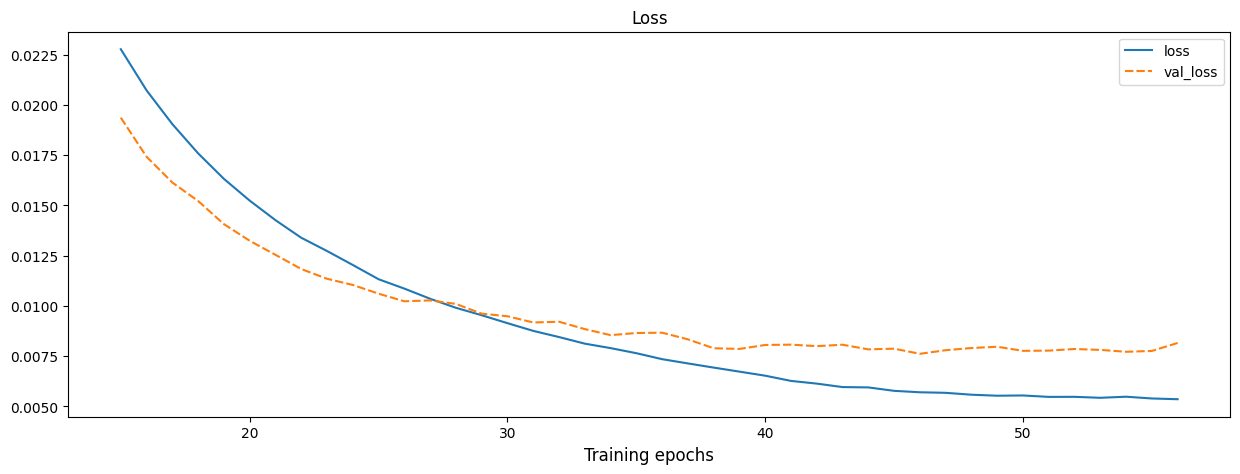

In [ ]:
history_df = pd.DataFrame.from_dict(history)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=history_df[['loss', 'val_loss']][15:], markers=False, ax=ax)
ax.set_xlabel("Training epochs", fontsize=12)
ax.set_title("Loss")

history_path = os.path.join("models", model_name + "_hist")
if not os.path.exists(history_path):
  os.mkdir(history_path)


plt.savefig(os.path.join(history_path, 'loss_graph'))

history_df.to_csv(os.path.join(history_path, 'training_stats'))

#### Option B: load previously saved model

In [ ]:
model_name = "32BiLSTMx3+32CNN+16CNN"
decoder = tfk.saving.load_model("models/{}".format(model_name))

## Step 4: evaluate on test data

*NOTE: this whole section is somewhat messy and might need refactoring in the future*

### 4.1 Preprocess and evaluate test data without losing information


Create a fitting object for test data.

Since it needs to be evaluated in different ways, sorted and analyzed, it is important to retain as much information as possible

In [ ]:
class TestSample:
  def __init__(self, snippet, y_true, y_pred):
    self.snippet = snippet
    self.y_true = y_true
    self.y_pred = y_pred

  def count_errors(self):
    round_pred = np.round(self.y_pred)
    return np.count_nonzero(self.y_true != round_pred)

  def get_misclassified_instructions(self):
    fp, fn = [], []
    round_pred = np.round(self.y_pred)
    for i in range(len(self.y_true)):
      if self.y_true[i] > round_pred[i]:
        fn.append(self.snippet.instructions[i])
      elif self.y_true[i] < round_pred[i]:
        fp.append(self.snippet.instructions[i])
      else:
        pass
    return fp, fn


Encode all test data

Note: can be reapplied only when encoding changes

In [ ]:
snippet_encoding_map = dict()

for snippet in test_snippets:
  input_seqs, input_labels, target_seqs = encode_snippet(snippet, window_len)
  input_seqs = np.stack(input_seqs)
  snippet_encoding_map[snippet] = (input_seqs, target_seqs)

Output streaming troncato alle ultime 5000 righe.
Size 18 will be extended to 256
Size 18 will be extended to 256
Size 53 will be extended to 256
Size 53 will be extended to 256
Size 57 will be extended to 256
Size 57 will be extended to 256
Size 8 will be extended to 256
Size 8 will be extended to 256
Size 9 will be extended to 256
Size 9 will be extended to 256
Size 19 will be extended to 256
Size 19 will be extended to 256
Size 67 will be extended to 256
Size 67 will be extended to 256
Size 57 will be extended to 256
Size 57 will be extended to 256
Size 17 will be extended to 256
Size 17 will be extended to 256
Size 18 will be extended to 256
Size 18 will be extended to 256
Size 48 will be extended to 256
Size 48 will be extended to 256
Size 19 will be extended to 256
Size 19 will be extended to 256
Size 19 will be extended to 256
Size 19 will be extended to 256
Size 15 will be extended to 256
Size 15 will be extended to 256
Size 21 will be extended to 256
Size 21 will be extended t

Evaluate all test data:

Note: Can be redone only when model is retrained

In [ ]:
test_samples = []
for snippet in test_snippets:
  padded_true = np.concatenate(snippet_encoding_map[snippet][1])
  y_true = np.resize(padded_true, len(snippet.target_seq))
  stacked_pred = decoder.predict(snippet_encoding_map[snippet][0])
  padded_pred = np.concatenate([array for array in stacked_pred])
  y_pred = np.resize(padded_pred, len(snippet.target_seq))
  print(len(snippet.target_seq), y_true.size, y_pred.size)
  test_samples.append(TestSample(snippet, y_true, y_pred))

print(len(test_samples))

Output streaming troncato alle ultime 5000 righe.
18 18 18
1/1 [==============================] - 0s 56ms/step
53 53 53
1/1 [==============================] - 0s 67ms/step
57 57 57
1/1 [==============================] - 0s 60ms/step
8 8 8
1/1 [==============================] - 0s 72ms/step
9 9 9
1/1 [==============================] - 0s 63ms/step
19 19 19
1/1 [==============================] - 0s 46ms/step
67 67 67
1/1 [==============================] - 0s 51ms/step
57 57 57
1/1 [==============================] - 0s 36ms/step
17 17 17
1/1 [==============================] - 0s 39ms/step
18 18 18
1/1 [==============================] - 0s 42ms/step
48 48 48
1/1 [==============================] - 0s 36ms/step
19 19 19
1/1 [==============================] - 0s 38ms/step
19 19 19
1/1 [==============================] - 0s 52ms/step
15 15 15
1/1 [==============================] - 0s 55ms/step
21 21 21
1/1 [==============================] - 0s 74ms/step
49 49 49
1/1 [===========================

### 4.2 Evaluate whole dataset

Setup directories to save data into

In [ ]:
model_name += str(window_len)
print(model_name)
report_dir = os.path.join("testing_reports", model_name)
if not os.path.exists(report_dir):
  os.mkdir(report_dir)

64BiLSTMx3+32CNN_unweighted_dropout03_window256256


Evaluate whole dataset

Particularly useful in the context of trying if a new model improved the previous in general

In [ ]:
def make_classification_report(test_samples, label, report_dir):
  report_name = "{}_report.txt".format(label)
  report_path = os.path.join(report_dir, report_name)
  with open(report_path, "w") as report:
    header = "{}_report".format(label)
    print(header, file=report)
    bulk_y_true = np.concatenate([sample.y_true for sample in test_samples])
    bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in test_samples])
    print(metrics.classification_report(bulk_y_true, bulk_y_pred, digits=4), file=report)

    seq_accuracy = [1 - sample.count_errors()/len(sample.y_true) for sample in test_samples]
    avg_accuracy = sum(seq_accuracy)/len(seq_accuracy)
    accuracy_text = "Model predicts sequences with an accuracy of {:0.2%}".format(avg_accuracy)
    print(accuracy_text, file=report)
  return report_path

def make_confusion_matrix(test_samples, label, report_dir):
  matrix_name = "{}_matrix.png".format(label)
  matrix_path = os.path.join(report_dir, matrix_name)

  bulk_y_true = np.concatenate([sample.y_true for sample in test_samples])
  bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in test_samples])
  cm = np.array(metrics.confusion_matrix(bulk_y_true, bulk_y_pred))

  fig, ax = plt.subplots(figsize=(10, 5))
  cm_labels = ["True Negative","False Positive","False Negative","True Positive"]
  cm_counts = [f"{value:g}" for value in cm.flatten()]
  cm_percs = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]
  annotations = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_labels, cm_counts, cm_percs)]
  annotations = np.asarray(annotations).reshape(2,2)
  sns.heatmap(cm, fmt='', annot=annotations, ax=ax, xticklabels=["Not Inlined", "Inlined"], yticklabels=["Not Inlined", "Inlined"], square=True, cbar=True) # Missing axis, labels on numbers
  ax.set_ylabel("Correct", fontsize=12)
  ax.set_xlabel("Predicted", fontsize=12)
  ax.set_title("Confusion matrix of class {}".format(label), fontsize = 15)

  plt.savefig(matrix_path)
  plt.show
  return matrix_path


general_report
              precision    recall  f1-score   support

           0     0.9389    0.9234    0.9311     25714
           1     0.9817    0.9856    0.9836    107071

    accuracy                         0.9735    132785
   macro avg     0.9603    0.9545    0.9573    132785
weighted avg     0.9734    0.9735    0.9734    132785

Model predicts sequences with an accuracy of 98.01%



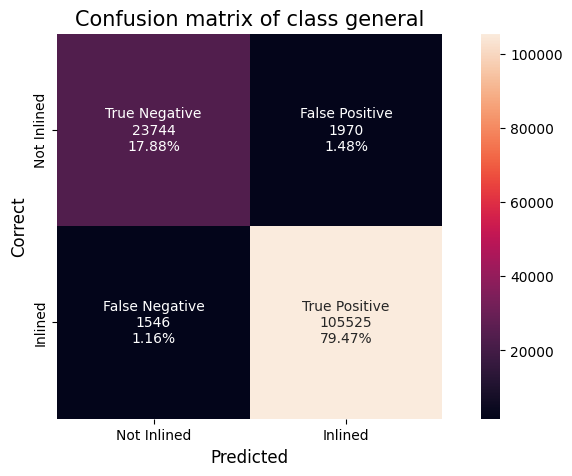

In [ ]:
#What if smaller methods are filtered out?
#big_test_samples = list(filter(lambda x: len(x.y_pred) > 20, test_samples))
#len(big_test_samples)
label = "general"
report_path = make_classification_report(test_samples, label, report_dir)
matrix_path = make_confusion_matrix(test_samples, label, report_dir)

with open(report_path, "r") as report:
  print(''.join(report.readlines()))


### 4.3 Evaluate by method and optimization

Cross-compare statistics regarding optimizations and methods

In [ ]:
label_report_dir = os.path.join(report_dir, "label related stats")
if not os.path.exists(label_report_dir):
  os.mkdir(label_report_dir)


In [ ]:
def get_metrics_dict(samples, target_names=['0', '1']):
  metrics_dict = dict()
  bulk_y_true = np.concatenate([sample.y_true for sample in samples])
  bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in samples])
  class_report = metrics.classification_report(bulk_y_true, bulk_y_pred, labels = [0, 1], target_names = target_names, output_dict = True)
  metrics_dict['Negative precision'] = class_report[target_names[0]]['precision']
  metrics_dict['Negative recall'] = class_report[target_names[0]]['recall']
  metrics_dict['Negative F1'] = class_report[target_names[0]]['f1-score']
  metrics_dict['Negative support'] = class_report[target_names[0]]['support']
  metrics_dict['Positive precision'] = class_report[target_names[1]]['precision']
  metrics_dict['Positive recall'] = class_report[target_names[1]]['recall']
  metrics_dict['Positive F1'] = class_report[target_names[1]]['f1-score']
  metrics_dict['Positive support'] = class_report[target_names[1]]['support']
  metrics_dict['Instruction-grain accuracy'] = metrics.accuracy_score(bulk_y_true, bulk_y_pred)

  seq_accuracy = [1 - sample.count_errors()/len(sample.y_true) for sample in samples]
  avg_accuracy = sum(seq_accuracy)/len(seq_accuracy)
  metrics_dict['Sequence-grain accuracy'] = avg_accuracy
  metrics_dict['Sequence number'] = len(seq_accuracy)
  return metrics_dict

In [ ]:
negative_metrics = ['Negative precision', 'Negative recall', 'Negative F1', 'Negative support']
positive_metrics = ['Positive precision', 'Positive recall', 'Positive F1', 'Positive support']
accuracy_metrics = ['Instruction-grain accuracy', 'Sequence-grain accuracy', 'Sequence number']
target_names = ['Not inlined', 'Inlined']

method_sorted_data = dict()
for m in sorted(METHODS):
  m_samples = [sample for sample in test_samples if sample.snippet.method == m]
  opt_sorted_data = dict()
  for o in ['-O2', '-O3', '-Os']:
    m_o_samples = [sample for sample in m_samples if sample.snippet.opt == o]
    if m_o_samples:
      metrics_dict = get_metrics_dict(m_o_samples, target_names)
    else:
      pass
    opt_sorted_data[o] = metrics_dict
  metrics_dict = get_metrics_dict(m_samples, target_names)
  opt_sorted_data["Overall"] = metrics_dict
  opt_sorted_data = pd.DataFrame.from_dict(opt_sorted_data, orient="columns")
  method_sorted_data[m] = opt_sorted_data

overall_opt_data = dict()
for o in ['-O2', '-O3', '-Os']:
    o_samples = [sample for sample in test_samples if sample.snippet.opt == o]
    if o_samples:
      metrics_dict = get_metrics_dict(o_samples, target_names)
    else:
      pass
    overall_opt_data[o] = metrics_dict
metrics_dict = get_metrics_dict(test_samples, target_names)
overall_opt_data["Overall"] = metrics_dict
overall_opt_data = pd.DataFrame.from_dict(overall_opt_data, orient="columns")
method_sorted_data["Overall"] = overall_opt_data

overall_df = pd.concat(method_sorted_data)


report_path = os.path.join(label_report_dir, "Method-Optimization cross table.txt")
with open(report_path, "w") as report:
  print(overall_df, file=report)
overall_df.to_csv(os.path.join(label_report_dir, "Method-Optimization cross table.csv"))

with open(report_path, "r") as report:
  print(''.join(report.readlines()))

                                                            -O2           -O3          -Os        Overall
std::deque::operator[] Negative precision              0.965649      0.976359     1.000000       0.965517
                       Negative recall                 0.980620      0.980998     1.000000       0.978313
                       Negative F1                     0.973077      0.978673     1.000000       0.971873
                       Negative support              258.000000    421.000000   138.000000     830.000000
                       Positive precision              0.996741      0.996400     1.000000       0.995936
                       Positive recall                 0.994148      0.995504     1.000000       0.993468
                       Positive F1                     0.995443      0.995951     1.000000       0.994701
                       Positive support             1538.000000   2224.000000   397.000000    4440.000000
                       Instruction-grain accur

In [ ]:
report_md_path = os.path.join(label_report_dir, "Method-Optimization cross table.md")
with open(report_md_path, "w") as report:
  print(overall_df.to_markdown(), file=report)

### 4.4 Evaluate by sequence length

Create length related reports folder

In [ ]:
length_report_dir = os.path.join(report_dir, "length-related stats")
if not os.path.exists(length_report_dir):
  os.mkdir(length_report_dir)

Evaluate samples sorted by blocksize

In [ ]:
max_block_size = 60
size_metrics_map = {}
negative_metrics = ['Negative precision', 'Negative recall', 'Negative F1', 'Negative support']
positive_metrics = ['Positive precision', 'Positive recall', 'Positive F1', 'Positive support']
accuracy_metrics = ['Instruction-grain accuracy', 'Sequence-grain accuracy', 'Sequence number']

target_names = ['Not inlined', 'Inlined']

for n in range(1, 60):
  metrics_dict = dict()
  n_sized_samples = [sample for sample in test_samples if (sample.snippet.blocksize == n)]
  if n_sized_samples:
    metrics_dict = get_metrics_dict(n_sized_samples, target_names)
    size_metrics_map[n] = metrics_dict
  else:
    pass


df = pd.DataFrame.from_dict(size_metrics_map, orient='index')
print(df)
overall_df.to_csv(os.path.join(length_report_dir, "Length related stats table.csv"))



    Negative precision  Negative recall  Negative F1  Negative support  Positive precision  Positive recall  Positive F1  Positive support  \
1             0.978757         0.987824     0.983270              3778            0.989588         0.981810     0.985684              4453   
2             0.960000         0.956217     0.958105              2284            0.966821         0.969717     0.968267              3005   
3             0.980631         0.947989     0.964034              1442            0.981831         0.993382     0.987573              4080   
4             0.972791         0.952318     0.962446              3041            0.983857         0.990917     0.987374              8918   
5             0.947764         0.916364     0.931800              2475            0.973427         0.983783     0.978578              7708   
6             0.960211         0.954898     0.957547              3614            0.987310         0.988850     0.988079             12825   
7     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Visualize negative statistics

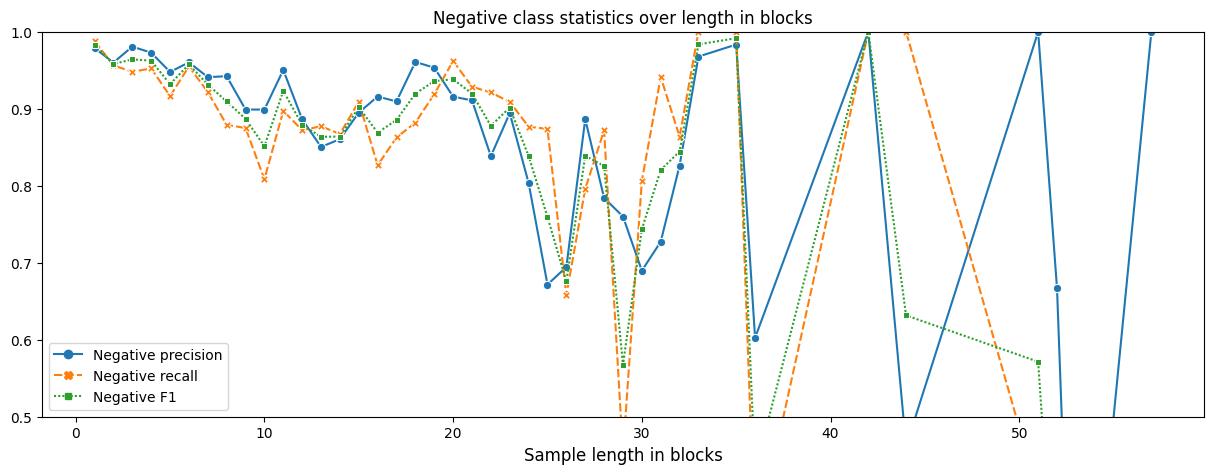

In [ ]:
min_support = 10
negative_data = df.loc[df['Negative support'] >= min_support]

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=negative_data[negative_metrics[:-1]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Negative class statistics over length in blocks")
ax.set_ylim(0.5, 1)

plt.savefig(os.path.join(length_report_dir, "Negative class statistics"))

Visualize positive statistics

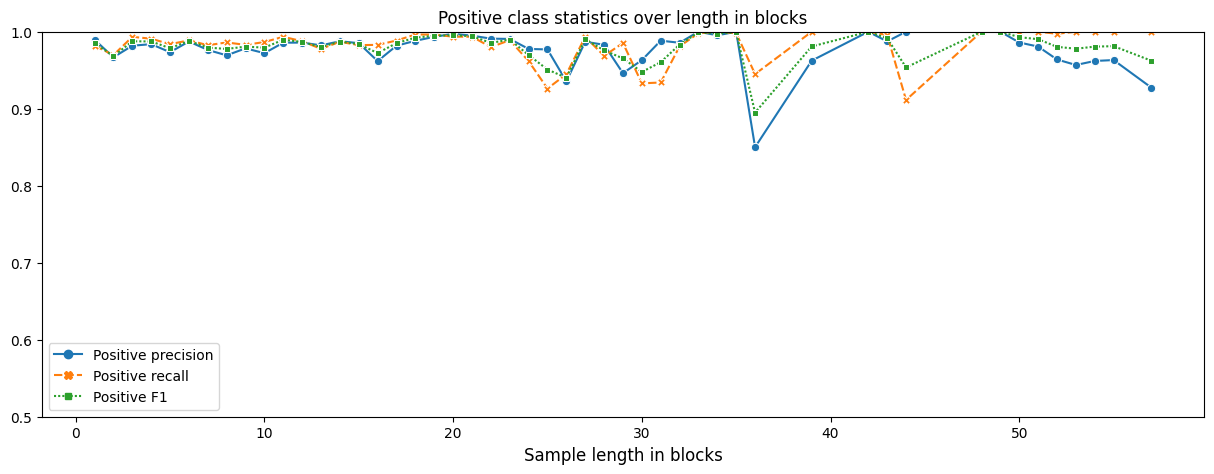

In [ ]:
min_support = 10
positive_data = df.loc[df['Positive support'] >= min_support]

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=positive_data[positive_metrics[:-1]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Positive class statistics over length in blocks")
ax.set_ylim(0.5, 1)
plt.savefig(os.path.join(length_report_dir, "Positive class statistics"))



Visualize accuracy statistics

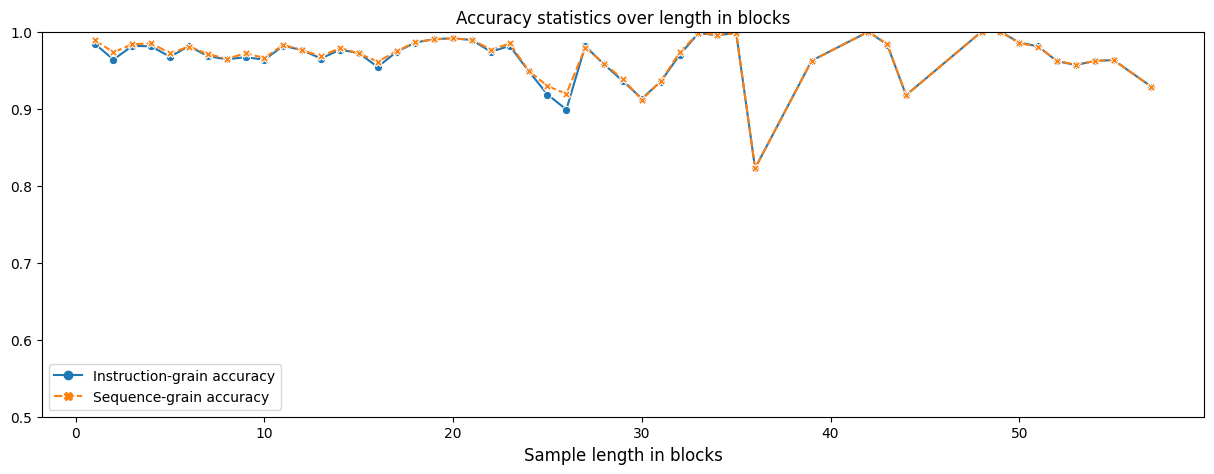

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df[accuracy_metrics[0:2]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Accuracy statistics over length in blocks")
ax.set_ylim(0.5, 1)
plt.savefig(os.path.join(length_report_dir, "Accuracy statistics"))